# Scrape Boston's 311 site with Selenium

### Imports

In [246]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import re
import pandas as pd
import matplotlib.pyplot as plt
# Enable inline plotting
%matplotlib inline

### Constants

In [247]:
BOSTON_URL = r'https://311.boston.gov'
SERVICE_ELEMS_XPATH = "//h3[contains(text(),'Services')]/following-sibling::ul/li"

### Scraper Class

In [248]:
class Scraper:
    """Class that scrapes 311.boston.gov"""
    
    def __init__(self, driver):
        self.report_urls = []
        self.driver = driver
        self.driver.get(BOSTON_URL)
        self.services = []
        self.get_services()
        
    def get_services(self):
        """Get service categories and service category count"""
        service_elems = self.driver.find_elements_by_xpath(SERVICE_ELEMS_XPATH)
        
        service_category_elems = [elem.find_element_by_xpath("./a") for elem in service_elems]
        service_count_elems = [elem.find_element_by_xpath("./span") for elem in service_elems]
        
        service_categories = [elem.text for elem in service_category_elems]
        service_counts = [int(''.join(re.findall('\d+', elem.text))) for elem in service_count_elems]
        
        self.services = list(zip(service_categories, service_counts))
        
    def get_reports_on_page(self):
        """Append report urls from a page onto self.report_urls"""
        report_ids = [elem.get_attribute("onclick").split("location.href='")[1][:-2]
                        for elem in self.driver.find_elements_by_class_name('report')]
        
        self.report_urls += [BOSTON_URL + report_id
                            for report_id in report_ids
                            if BOSTON_URL + report_id not in self.report_urls]
        
    def next_page(self):
        """Go to next page"""
        next_page_button = self.driver.find_element_by_xpath("//li/a[contains(text(),'Next')]")
        next_page_button.click()
        
    def search_for(self, search_text):
        """Search for inputed text in search field and go to the results"""
        search_box = self.driver.find_element_by_class_name('search-query')
        search_box.send_keys(search_text)
        search_box.send_keys(Keys.ENTER)

In [249]:
driver = webdriver.Chrome()

In [250]:
scraper = Scraper(driver)

In [251]:
scraper.get_reports_on_page()
scraper.next_page()
scraper.get_reports_on_page()

In [15]:
scraper.report_urls

['https://311.boston.gov/reports/101002276877',
 'https://311.boston.gov/reports/101002276975',
 'https://311.boston.gov/reports/101002276873',
 'https://311.boston.gov/reports/101002276974',
 'https://311.boston.gov/reports/101002276910',
 'https://311.boston.gov/reports/101002276944',
 'https://311.boston.gov/reports/101002276972',
 'https://311.boston.gov/reports/101002276973',
 'https://311.boston.gov/reports/101002276971',
 'https://311.boston.gov/reports/101002276939']

### Report Class

In [252]:
class Report:
    """Handles information for individual reports"""
    
    def __init__(self, driver, report_url):
        self.driver = driver
        self.report_url = report_url
        self.driver.get(self.report_url)
        
        self.report_dict = {}
        
    def get_id(self):
        """Gets the ID of the ticket using the current URL"""
        self.report_dict['id'] = self.report_url.split('/')[-1]
        
    def get_status(self):
        """Gets the status (Opened, Closed, Submitted) of the report"""
        self.report_dict['status'] = self.driver.find_element_by_class_name("label").text
        
    def get_description(self):
        """Gets user-submitted description of the report"""
        self.report_dict['description'] = self.driver.find_element_by_xpath("//blockquote/p").text
        
    def get_closing_info(self):
        """Gets the case comment, if it exists, and timestamp"""
        if self.report_dict['status'] == "CLOSED":
            # Click on the Notes tab
            self.driver.find_element_by_xpath("//a[@href='#notes-tab']").click()
            
            # Get all items from the table, then organize in tuples
            notes_table_elem = self.driver.find_element_by_xpath("//div[@id='notes-tab']/table/tbody")
            row_elems = notes_table_elem.find_elements_by_xpath("./tr/td")
            
            self.report_dict['time closed'] = row_elems[0].text
            self.report_dict['case comment'] = row_elems[1].text
        else:
            self.report_dict['case comment'] = ""
            self.report_dict['time closed'] = ""
        
    def get_category(self):
        """Gets the category of the case"""
        self.report_dict['category'] = self.driver.find_element_by_xpath("//div[@class='content-head']/h2")\
        .text.split(" at ")[0]

### Make a list of report objects

In [253]:
report_dicts = []
for url in scraper.report_urls:
    report = Report(driver, url)
    report.get_id()
    report.get_status()
    report.get_category()
    report.get_description()
    report.get_closing_info()
    report_dicts.append(report.report_dict)

report_dicts

[{'case comment': '',
  'category': 'Illegal Graffiti',
  'description': 'Please remove graffiti on dumpster',
  'id': '101002277073',
  'status': 'OPENED',
  'time closed': ''},
 {'case comment': '',
  'category': 'Litter',
  'description': 'Please cut weeds growing out of city sidewalk',
  'id': '101002277072',
  'status': 'OPENED',
  'time closed': ''},
 {'case comment': '',
  'category': 'Illegal Graffiti',
  'description': 'Please remove stickers on sign',
  'id': '101002277070',
  'status': 'OPENED',
  'time closed': ''},
 {'case comment': '',
  'category': 'Needle Clean-up',
  'description': 'Needle under bench in Chester Sq. park directly in front of 545 Mass. Ave.',
  'id': '101002277071',
  'status': 'OPENED',
  'time closed': ''},
 {'case comment': '',
  'category': 'Overflowing Trash Can',
  'description': 'Overflowing can and litter all over sidewalk',
  'id': '101002277068',
  'status': 'OPENED',
  'time closed': ''},
 {'case comment': '',
  'category': 'Street Lights',
 

### Organize the dataframes

#### Report dataframe

In [254]:
column_headers = ['id', 'status', 'category', 'description', 'time closed', 'case comment']
report_df = pd.DataFrame(report_dicts, columns=column_headers)

In [255]:
report_df.to_csv('report_info.csv', header=True)

In [256]:
loc = r'./report_info.csv'
df = pd.read_csv(loc)
df

,Unnamed: 0,id,status,category,description,time closed,case comment
0,0,101002277073,OPENED,Illegal Graffiti,Please remove graffiti on dumpster,NaN,NaN
1,1,101002277072,OPENED,Litter,Please cut weeds growing out of city sidewalk,NaN,NaN
2,2,101002277070,OPENED,Illegal Graffiti,Please remove stickers on sign,NaN,NaN
3,3,101002277071,OPENED,Needle Clean-up,Needle under bench in Chester Sq. park directl...,NaN,NaN
4,4,101002277068,OPENED,Overflowing Trash Can,Overflowing can and litter all over sidewalk,NaN,NaN
5,5,101002277069,OPENED,Street Lights,4 Led street lights out on Truman pkwy,NaN,NaN
6,6,101002277001,CLOSED,Dead Animal Pick-up,Dead rat on sidewalk,"Sat Dec 02, 2017 04:58pm",Closed with status: Case Resolved. Upon arriva...
7,7,101002277067,OPENED,Dead Animal Pick-up,Dead rat in public alley 417 right by Fairfiel...,NaN,NaN
8,8,101002277066,OPENED,Litter,Someone continues to throw out construction de...,NaN,NaN
9,9,101002277065,OPENED,Illegal Parking,How is the car parked illegally? Other | Detai...,NaN,NaN


#### Scraper dataframe

In [257]:
services_df = pd.DataFrame(scraper.services, columns=['category', 'count'])
services_df.to_csv('services_info.csv', header=True)
services_df

,category,count
0,Schedule a Bulk Item Pickup,131494
1,Other,103546
2,Litter,86981
3,Roadway Plowing/Salting,73169
4,Missed Trash or Recycling,72290
5,Illegal Parking,69058
6,Recycling Cart,57672
7,Street Lights,57605
8,Pothole,55600
9,Pothole (Internal),49713


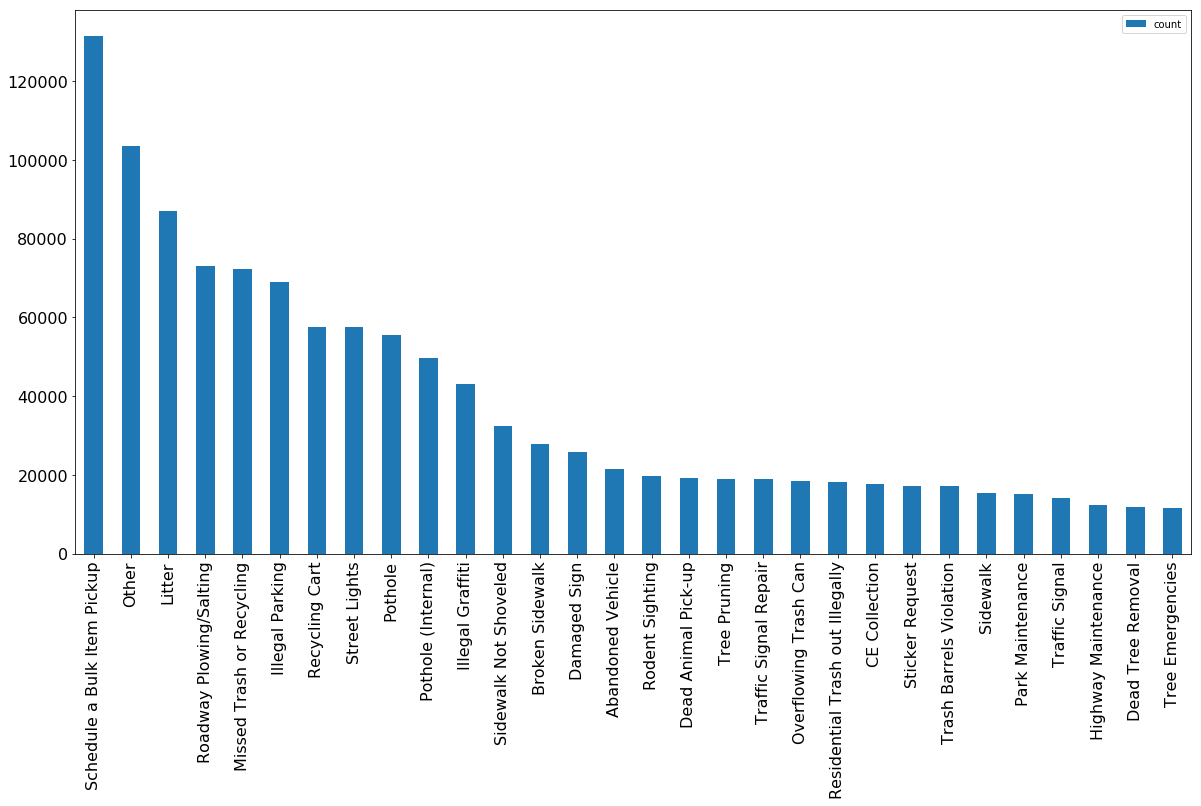

In [258]:
loc = r'./services_info.csv'
services_df = pd.read_csv(loc, usecols=[1,2])
categories = services_df['category'].tolist()


services_plot = services_df.plot(kind='bar', figsize=(20, 10), fontsize=16)
services_plot.set_xticklabels(categories, rotation='vertical')
plt.show()

In [ ]:
#  # TODO: cases for notes tab
#     def get_notes_tab(self):
#         """Gets info inside the notes tab"""
#         # Click on the Notes tab
#         self.driver.find_element_by_xpath("//a[@href='#notes-tab']").click()
        
#         # Get all items from the table, then organize in tuples
#         notes_table_elem = self.driver.find_element_by_xpath("//div[@id='notes-tab']/table/tbody")
#         table_elems = notes_table_elem.find_elements_by_xpath("./tr/td")
#         table_elems = [elem.text for elem in table_elems]
#         row_data = list(zip(table_elems[0::2], table_elems[1::2]))
        
#         # Three cases
#         # 1. Submitted - 1 row
#         # 2. Opened - 2 rows
#         # 3. Closed - 3 rows

#         # Get submit info
#         submit_row = row_data[-1]
#         self.report_dict['time submitted'] = submit_row[0]
#         self.report_dict['submitted using'] = submit_row[1].split(" ")[-1]
        
#         # Get open info
#         if len(row_data) >= 2:
#             open_row = row_data[-2]
#             self.report_dict['time opened'] = open_row[0]
#             self.report_dict['open description'] = open_row[1]
            
#         # Get closed info
#         if len(row_data) == 3:
#             closed_row = row_data[0]
#             self.report_dict['time closed'] = closed_row[0]
#             self.report_dict['closing description'] = closed_row[1]